# 1.Necessary libraries

In [1]:
# system libraries and data import:
import os
import time
import random 
import zipfile
import shutil
from shutil import copyfile
from google.colab import drive

# Basic libraries for data science/Pretreatment:
import numpy as np
import pandas as pd

# Graphics and image visualization:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Split main dataset into train, test and val folders:
!pip install split-folders
import splitfolders

# Image generator, import and preprocessing:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from collections import Counter

# models, parameters and evaluation metrics:
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1
from keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from sklearn.metrics import confusion_matrix
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2.Dataset import

### Google drive connection

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Back up code cells

This cell was developed to delet "dataset_splited" folder.

In [ ]:
#deletes "dataset_splited" folder.
#shutil.rmtree("/content/dataset_splited")

This cell was developed to be run just in case the oversampling and undersampling cells were run more than just one time. For more information read the txt. Requirements, notes section.

In [ ]:
#deletes "balanced_training_folder" folder.
#shutil.rmtree(path + main_folder + balanced_training_folder) 

### Connection string + zip file extraction

In [4]:
# Set connection string
path = "/content/drive/MyDrive/Group 3 - CNN Sentiment analisys/"

# Transfer zip dataset to the current virtual machine
copyfile(path + 'emotions_dataset.zip','dataset.zip')

# Extract files
zip_file = zipfile.ZipFile('dataset.zip')
zip_file.extractall()
zip_file.close()

# Define the sub-folders
path = "/content/"
main_folder, angry_folder, disgust_folder, fear_folder, happy_folder, neutral_folder, sad_folder, surprise_folder = "emotions_dataset/", "angry/", "disgust/", "fear/", "happy/", "neutral/", "sad/","surprise/"

### Split dataset: Training, Validation and Test folders

In [ ]:
#Dataset splited in 70/20/10
input_folder= "/content/emotions_dataset"

splitfolders.ratio(input_folder, output="/content/drive/MyDrive/Group 3 - CNN Sentiment analisys/dataset_splited",
    seed=42, ratio=(.7, .2, .1), 
    group_prefix=None, move=False)

Copying files: 2631 files [26:23,  1.64 files/s]

# 3.Dataset exploration

### 1st data check

In [ ]:
#Global variables

path = "/content/drive/MyDrive/Group 3 - CNN Sentiment analisys/"
main_folder="dataset_splited/"
training_folder="train/"
validation_folder="val/"
testing_folder="test/"
balanced_training_folder = "train_balanced/"
class_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad","surprise"]

In [ ]:
# Number of images per splited folders and class
for split in [training_folder, testing_folder, validation_folder]:
    for c in class_labels:
        n_train_c = len(os.listdir(path + main_folder + split + f"{c}"))
        print(f"{split} Nº of img of class {c} : {n_train_c}")

train/ Nº of img of class angry : 3467
train/ Nº of img of class disgust : 382
train/ Nº of img of class fear : 3584
train/ Nº of img of class happy : 6292
train/ Nº of img of class neutral : 4338
train/ Nº of img of class sad : 4253
train/ Nº of img of class surprise : 2801
test/ Nº of img of class angry : 496
test/ Nº of img of class disgust : 56
test/ Nº of img of class fear : 513
test/ Nº of img of class happy : 900
test/ Nº of img of class neutral : 621
test/ Nº of img of class sad : 609
test/ Nº of img of class surprise : 401
val/ Nº of img of class angry : 990
val/ Nº of img of class disgust : 109
val/ Nº of img of class fear : 1024
val/ Nº of img of class happy : 1797
val/ Nº of img of class neutral : 1239
val/ Nº of img of class sad : 1215
val/ Nº of img of class surprise : 800


### Visualization of data distribution

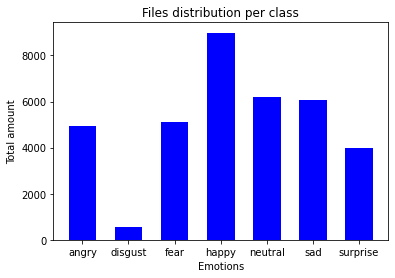

In [ ]:
#Global data distribution 
fig, ax = plt.subplots()

data = [len(os.listdir("/content/emotions_dataset/" + f"{c}")) for c in class_labels]

ax.bar(class_labels, data, color ='blue', width = 0.6)

ax.set_ylabel('Total amount')
ax.set_xlabel('Emotions')
ax.set_title("Files distribution per class")

plt.show()

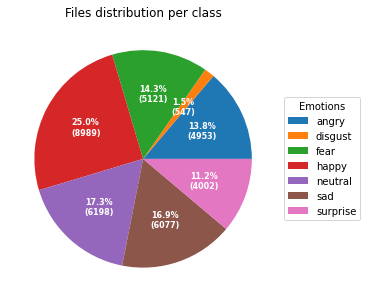

In [ ]:
#Percentage of data distribution 
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

data = [len(os.listdir("/content/emotions_dataset/" + f"{c}")) for c in class_labels]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


slices, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(slices, class_labels,
          title="Emotions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Files distribution per class")

plt.show()

### Dataset sampling examples

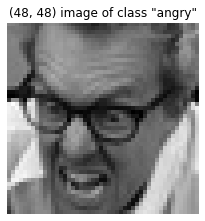

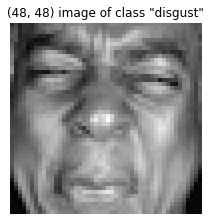

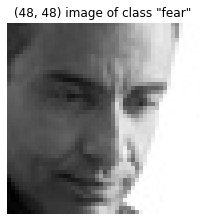

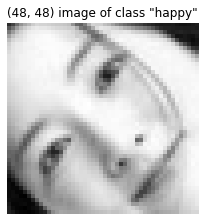

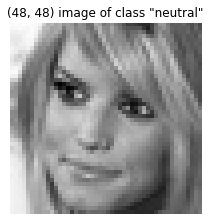

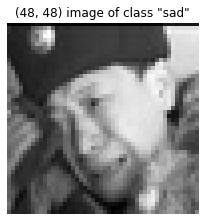

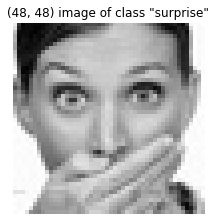

In [ ]:
def show_sample_images(folder_directory):
    # Build a connection string
    for c in class_labels:
      full_path = folder_directory + f"{c}" + "/"
      # Get a set of random images
      images = random.sample(os.listdir(full_path), 1)
      # Plot the images
      fig=plt.figure(figsize=(10, 20))
      for i, img in enumerate(images):
          img = mpimg.imread(full_path + img)
          ax = plt.subplot(7, 1, i + 1)
          plt.imshow(img, cmap='gray') 
          plt.title("{} image of class \"{}\"".format(img.shape, f"{c}"))
          plt.axis("off")
          plt.tight_layout() 

show_sample_images(path + main_folder + training_folder)

### Visualization of data distribution after training, validation and test split

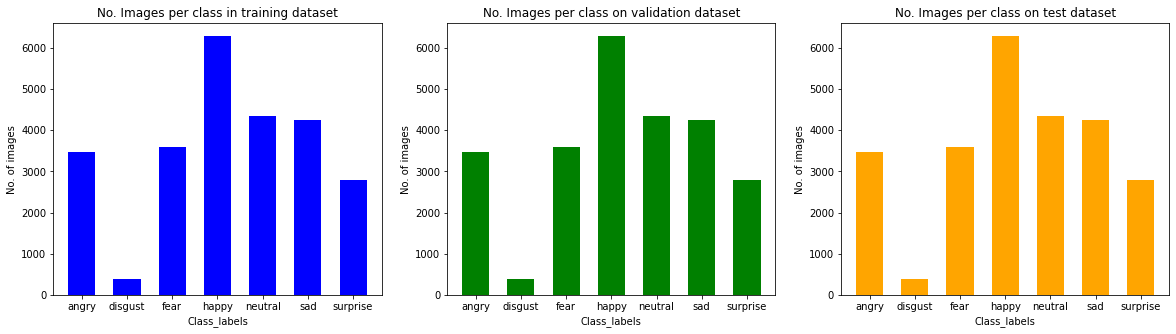

In [ ]:
# creating the dataset
y_train = [len(os.listdir(path + main_folder + training_folder + f"{c}")) for c in class_labels]
y_val = [len(os.listdir(path + main_folder + training_folder + f"{c}")) for c in class_labels]
y_test = [len(os.listdir(path + main_folder + training_folder + f"{c}")) for c in class_labels]

#Fig. dimentions
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.subplot(1,3,1)
plt.bar(class_labels, y_train, color ='blue',
        width = 0.6)
plt.title("No. Images per class in training dataset")
plt.ylabel("No. of images")
plt.xlabel("Class_labels")

plt.subplot(1,3,2)
plt.bar(class_labels, y_val, color ='green',
        width = 0.6)

plt.ylabel("No. of images")
plt.xlabel("Class_labels")
plt.title("No. Images per class on validation dataset")

plt.subplot(1,3,3)
plt.bar(class_labels, y_test, color ='orange',
        width = 0.6)

plt.ylabel("No. of images")
plt.xlabel("Class_labels")
plt.title("No. Images per class on test dataset")

plt.show()

#meter teste e validation no mesmo grafico

# 4.Dataset treatment

## Treat imbalance data set

###Class_weights

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(path + main_folder + training_folder)

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

Found 25117 images belonging to 7 classes.


{0: 1.8148254975483127,
 1: 16.471204188481675,
 2: 1.7555803571428572,
 3: 1.0,
 4: 1.450437989857077,
 5: 1.479426287326593,
 6: 2.246340592645484}

### Dataset balancing deployment:

Oversampling minoritary class


Counting files without balanced performance

In [ ]:
#Two minoritary classes to be oversample: Disgust and Surprise
disgust_ = os.listdir(path + main_folder + training_folder + disgust_folder)
print("No. of disgust files without oversampling is:", len(disgust_))

surprise_ = os.listdir(path + main_folder + training_folder + surprise_folder)
print("No. of surprise files without oversampling is:", len(surprise_))

#One major class to be undersample: Happy
happy_ = os.listdir(path + main_folder + training_folder + happy_folder)
print("No. of happy files without undersampling is:", len(happy_))

No. of disgust files without oversampling is: 382
No. of surprise files without oversampling is: 2801
No. of happy files without undersampling is: 6292


Global variables

In [ ]:
# Source path 
src = path + main_folder + training_folder

# Destination path 
dest = path + main_folder + balanced_training_folder

# Copy the content of source to destination 
destination = shutil.copytree(src, dest)

#Parameters for datagenerator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Disgust class oversampling:

In [ ]:
for img_name in disgust_:
  img = load_img(path + main_folder + balanced_training_folder + disgust_folder + f"{img_name}")  
  x = img_to_array(img)  
  x = x.reshape((1,) + x.shape) 
  #print(x.shape)

  i = 0
  for batch in datagen.flow(x,
                            save_to_dir= path + main_folder + balanced_training_folder + disgust_folder, save_prefix= 'disgust', save_format='jpeg'):
    i +=1
    if i > 10:
      break

Surprise class oversampling:

In [ ]:
# Surprise class oversampling:
for img_name in surprise_:
  img = load_img(path + main_folder + balanced_training_folder + surprise_folder + f"{img_name}")  
  x = img_to_array(img)  
  x = x.reshape((1,) + x.shape) 
  #print(x.shape)

  i = 0
  for batch in datagen.flow(x,
                            save_to_dir= path + main_folder + balanced_training_folder + surprise_folder, save_prefix= 'surprise', save_format='jpeg'):
    i +=1
    if i > 0:
      break

Undersampling majoritary class

In [ ]:
src = path + main_folder + balanced_training_folder + happy_folder
img_drop_n = 1000 
img_names = os.listdir(src)

#Random image selector
img_names = random.sample(img_names, img_drop_n)

# Remove the image
for image in img_names:
    f = os.path.join(src, image)
    os.remove(f)  

Counting oversampled and undersampled file classes

In [ ]:
#Two minoritary classes oversampled: Disgust and Surprise
disgust_ = os.listdir(path + main_folder + balanced_training_folder + disgust_folder)
print("No. of disgust files with oversampling is:", len(disgust_))

surprise_ = os.listdir(path + main_folder + balanced_training_folder + surprise_folder)
print("No. of surprise files with oversampling is:", len(surprise_))

#One major class undersampled: Happy
happy_ = os.listdir(path + main_folder + balanced_training_folder + happy_folder)
print("No. of happy files with undersampling is:", len(happy_))

No. of disgust files with oversampling is: 3844
No. of surprise files with oversampling is: 5247
No. of happy files with undersampling is: 5292


Data distribution after imbalance treatment

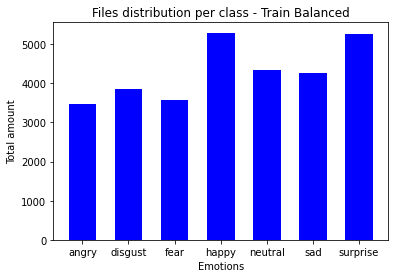

In [ ]:
fig, ax = plt.subplots()

data = [len(os.listdir(path + main_folder + balanced_training_folder + f"{c}")) for c in class_labels]

ax.bar(class_labels, data, color ='blue',
        width = 0.6)

ax.set_ylabel('Total amount')
ax.set_xlabel('Emotions')
ax.set_title("Files distribution per class - Train Balanced")

plt.show()

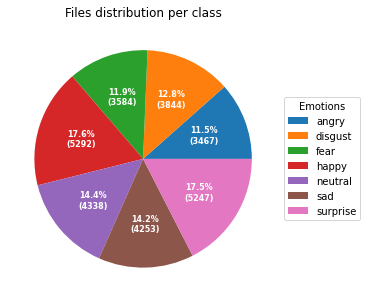

In [ ]:
#Percentage of data distribution 
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

data = [len(os.listdir(path + main_folder + balanced_training_folder + f"{c}")) for c in class_labels]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


slices, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(slices, class_labels,
          title="Emotions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Files distribution per class")

plt.show()

## Loading data into virtual machine

Defines a list of parameters for the image_dataset_from_directory.

In [ ]:
image_size=(48,48)                            # is being set to (128, 125), which means that all images will be resized to have a width and height of 64 pixels. ( PERGUNTAR DE DEVEMOS MUDAR TENDO EM CONTA QUE AS IMAGENS SÃO 28,28)
crop_to_aspect_ratio = True                   # being set to True, meaning that images will be cropped to maintain their aspect ratio when resized.
color_mode='rgb'                              # set to 'rgb', indicating that the images are in RGB format (as opposed to grayscale). (PERGUNTAR À PROFESSORA)
batch_size= 200                               # being set to 200, which means that the images will be divided into groups of 200 for training and validation. This value can be adjusted if overfitting or underfitting is observed.
label_mode= "categorical"                     # set to 'categorical', indicating that the labels for the images are in the form of categorical classes rather than numerical values.
validation_split=1                            # is set to 1, which means that all data will be used for validation.
shuffle=True                                  # set to True, indicating that the dataset will be shuffled before each epoch of training.
seed=0                                        # set to 0, which means that the random number generator used to shuffle the dataset will be initialized with a seed of 0.
patience=5                                    
epochs = 100

### Loading data

In [ ]:
# Create training dataset
ds_train = image_dataset_from_directory(path + main_folder + training_folder,
                                        image_size=image_size,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        label_mode=label_mode,
                                        shuffle=shuffle,
                                        seed=seed)

# Create training dataset with balanced data
ds_train_balanced = image_dataset_from_directory(path + main_folder + balanced_training_folder,
                                        image_size=image_size,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        label_mode=label_mode,
                                        shuffle=shuffle,
                                        seed=seed)
# Create Validation dataset
ds_val = image_dataset_from_directory(path + main_folder + validation_folder,
                                      image_size=image_size,
                                      crop_to_aspect_ratio=crop_to_aspect_ratio,
                                      color_mode=color_mode,
                                      batch_size=batch_size,
                                      label_mode=label_mode,
                                      shuffle=shuffle,
                                      seed=seed)
# Create test dataset
ds_test = image_dataset_from_directory(path + main_folder + testing_folder,
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=3596,
                                       label_mode=label_mode,                                   
                                       shuffle= False,
                                       seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

print("\nObject's type:\t", type(ds_train_balanced))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train_balanced, tf.data.Dataset))
print("Classes:", ds_train_balanced.class_names)

Found 25117 files belonging to 7 classes.
Found 30025 files belonging to 7 classes.
Found 7174 files belonging to 7 classes.
Found 3596 files belonging to 7 classes.

Object's type:	 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Object's type:	 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Split X and y variables 

In [ ]:
# Imbalaced train ds
iter_train = iter(ds_train) 
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of y_train:", batch_y_train[0:7])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

# Balaced train ds
iter_train_BAL = iter(ds_train_balanced) 
batch_x_train_BAL, batch_y_train_BAL = iter_train_BAL.next()
print(batch_x_train_BAL.shape, batch_y_train_BAL.shape)
print("\nSample of y_train:", batch_y_train_BAL[0:7])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train_BAL))

# Validation ds
iter_val = iter(ds_val)
batch_x_val, batch_y_val = iter_val.next()
print(batch_x_val.shape, batch_y_val.shape)
print("\nSample of y_val:", batch_y_val[0:7])
print("Sample average of y_val:", tf.reduce_mean(batch_y_val))

# Test ds
iter_test = iter(ds_test) 
batch_x_test, batch_y_test = iter_test.next()
print(batch_x_test.shape, batch_y_test.shape)
print("\nSample of y_test:", batch_y_test[0:7])
print("Sample average of y_test:", tf.reduce_mean(batch_y_test))

(200, 48, 48, 3) (200, 7)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]], shape=(7, 7), dtype=float32)
Sample average of y_train: tf.Tensor(0.14285715, shape=(), dtype=float32)
(200, 48, 48, 3) (200, 7)

Sample of y_train: tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]], shape=(7, 7), dtype=float32)
Sample average of y_train: tf.Tensor(0.14285715, shape=(), dtype=float32)
(200, 48, 48, 3) (200, 7)

Sample of y_val: tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]], shape=(7, 7), dtype=float32)
Sample average of y_val: tf.Tensor(0.14285715, shape=(), dtype=float32)
(3596, 48, 48,

Plot images loaded with iter_train object

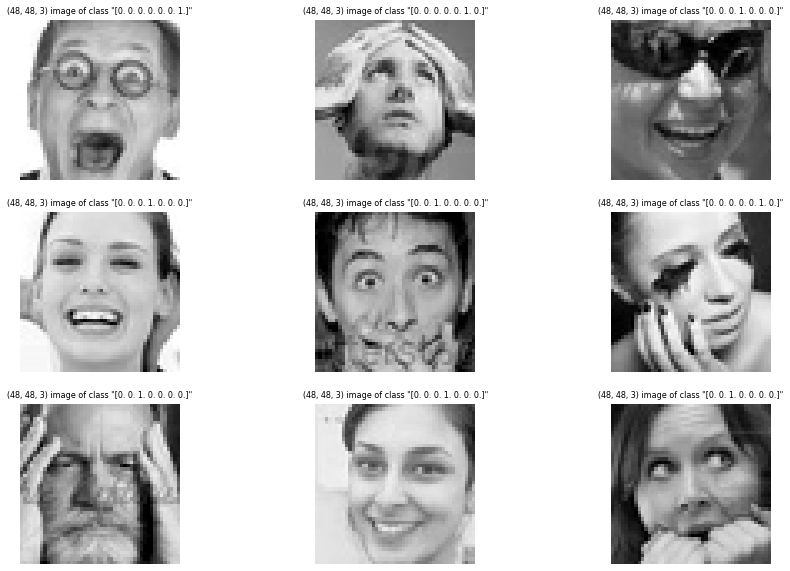

In [ ]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(15, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

show_sample_batch(ds_train)

### Rescaling

In [ ]:
rescaling = layers.BatchNormalization()

#5.Models deployment

Two different approaches.

*   Balanced dataset (ds_train_balanced);
*   Original dataset (ds_train).




In [ ]:
#Global variables

early_stop = EarlyStopping(patience=patience, monitor='val_loss', mode='min', restore_best_weights=True)
input_shape = batch_x_train.shape
learning_rate = 0.001
num_classes = 7


## Simple Models 
Classes based





Basic model 1

In [ ]:
#Model 1 - imbalanced dataset

cnn1 = Sequential([
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed)), layers.Activation("relu"),   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed)), layers.Activation("relu"),   layers.GlobalMaxPooling2D(),
              
                   layers.Dense(units=7, activation="softmax",  kernel_initializer=initializers.GlorotNormal(seed=seed))])



# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn1.build(input_shape)


cnn1.summary()


cnn1.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
                      Recall(name='recall'),
                      AUC(name='AUC')])


# Start Time
start = time.time()

history1 = cnn1.fit(ds_train, class_weight = class_weights, 
                    epochs=epochs,
                    callbacks=[early_stop], 
                    validation_data=ds_val)

# Measure the end time
print("Training time: {:.4f}s".format(time.time() - start))


# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(history1.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
#Model 1 - balanced dataset

cnn1_1 = Sequential([
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed)), layers.Activation("relu"),   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed)), layers.Activation("relu"),   layers.GlobalMaxPooling2D(),
              
                   layers.Dense(units=7, activation="softmax",  kernel_initializer=initializers.GlorotNormal(seed=seed))])


# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn1_1.build(input_shape)



cnn1_1.summary()


cnn1_1.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
                      Recall(name='recall'),
                      AUC(name='AUC')])


# Start Time
start = time.time()

history1_1 = cnn1_1.fit(ds_train_balanced, 
                    epochs=epochs,
                    callbacks=[early_stop], 
                    validation_data=ds_val)

# Measure the end time
print("Training time: {:.4f}s".format(time.time() - start))


# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(history1_1.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
#Model 1 - balanced dataset 
#REGULARIZER added

cnn1_2 = Sequential([
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),   layers.GlobalMaxPooling2D(),
              
                   layers.Dense(units=7, activation="sigmoid",  kernel_initializer=initializers.GlorotNormal(seed=seed))])



# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn1_2.build(input_shape)


cnn1_2.summary()


cnn1_2.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
                      Recall(name='recall'),
                      AUC(name='AUC')])



# Start Time
start = time.time()

history1_2 = cnn1_2.fit(ds_train_balanced, 
                    epochs=epochs,
                    callbacks=[early_stop],
                    validation_data=ds_val)

# Measure the end time
print("Training time: {:.4f}s".format(time.time() - start))


# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(history1_2.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()



Basic model 2

In [ ]:
#Model 2 - balanced dataset 
#Ativation = softmax


# Architecture v1
cnn2 = Sequential([
                   layers.BatchNormalization(),

                   layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)),
                   
                   layers.Activation("relu"), layers.MaxPooling2D(pool_size=(2, 2)),

                   layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), 
                   layers.Activation("relu"), layers.GlobalMaxPooling2D(),
                  
                   layers.Dense(units=7, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn2.build(input_shape)


cnn2.summary()


cnn2.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
                      Recall(name='recall'),
                      AUC(name='AUC')])

# Model training (v1)
history2 = cnn2.fit(ds_train_balanced, 
                      callbacks=[early_stop],
                      epochs=epochs, validation_data=ds_val)



df_hist1 = pd.DataFrame.from_dict(history2.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Basic model 3


In [ ]:
#Model 3 - balanced dataset 
#Conv2D filters from 64 to 128
                
# Architecture v1
cnn3 = Sequential([
                   layers.BatchNormalization(),

                   layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),layers.MaxPooling2D(pool_size=(2, 2)),

                   layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"), layers.GlobalMaxPooling2D(),
                   
                   layers.Dense(units=7, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn3.build(input_shape)


cnn3.summary()


cnn3.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
                      Recall(name='recall'),
                      AUC(name='AUC')])

# Model training (v1)
history3 = cnn3.fit(ds_train_balanced, epochs=epochs, 
                      callbacks=[early_stop],
                      validation_data=ds_val)  

# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(history3.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Basic model 4

In [ ]:
#Model 4 - balanced dataset 
# strides=(2, 2), filtres from 128 256
               
# Architecture v1
cnn4 = Sequential([
                   layers.BatchNormalization(),
                   
                   layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2),  kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2),  kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   
                   layers.Dense(units=7,  activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn4.build(input_shape)


cnn4.summary()  


cnn4.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')])

# Model training
history4 = cnn4.fit(ds_train_balanced, 
                      callbacks=[early_stop],
                      epochs=epochs, 
                      validation_data=ds_val)

df_hist4= pd.DataFrame.from_dict(history4.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Basic model 5

In [ ]:
#Model 5 - balanced dataset 
#padding='valid', filters from 256 to 512
              
# Architecture v1
cnn5 = Sequential([
                   layers.BatchNormalization(),
                   
                   layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1),  padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   
                   layers.Dense(units=7,  activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed))])


# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn5.build(input_shape)


cnn5.summary()  

# Start Time
start = time.time()


cnn5.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')])

# Model training
history5 = cnn5.fit(ds_train_balanced, 
                      epochs=epochs, 
                      callbacks=[early_stop],
                      validation_data=ds_val)

# Measure the end time
print("Training time: {:.4f}s".format(time.time() - start))


df_hist1 = pd.DataFrame.from_dict(history5.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Basic model 6

In [ ]:
#Model 6 - balanced dataset 
#kernel_size=(5, 5), layers.Flatten()
                               
# Architecture v1
cnn6 = Sequential([
                   layers.BatchNormalization(),
                   
                   layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2),  padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed),kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=512, kernel_size=(5, 5), strides=(2, 2), padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed),kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),

                   layers.Flatten(),
                   
                   layers.Dense(units=7,  activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn6.build(input_shape)


cnn6.summary()  

# Start Time
start = time.time()


cnn6.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')])

# Model training
history6 = cnn6.fit(ds_train_balanced, 
                      epochs=epochs, 
                      callbacks=[early_stop],
                      validation_data=ds_val)

# Measure the end time
print("Training time: {:.4f}s".format(time.time() - start))


df_hist1 = pd.DataFrame.from_dict(history6.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Basic model 7

In [ ]:
#Model 7 - balanced dataset 
#added more convolutional layers
                
# Architecture v1
cnn7 = Sequential([
                   layers.BatchNormalization(),        
                   
                   layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1),  padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"), layers.MaxPooling2D(pool_size=(2, 2)),

                   layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),  layers.MaxPooling2D(pool_size=(2, 2)),
                   
                   layers.Conv2D(filters=512, kernel_size=(5, 5), strides=(1, 1), padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),  layers.GlobalMaxPooling2D(),                
                   
                   layers.Flatten(),
                   
                   layers.Dense(units=7,  activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed))])


# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn7.build(input_shape)


cnn7.summary()  

# Start Time
start = time.time()


cnn7.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')])

# Model training
history7 = cnn7.fit(ds_train_balanced, 
                      epochs=epochs, 
                      callbacks=[early_stop],
                      validation_data=ds_val)

# Measure the end time
print("Training time: {:.4f}s".format(time.time() - start))


df_hist1 = pd.DataFrame.from_dict(history7.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)
# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Basic model 8

In [ ]:
#Model 8 - balanced dataset 
#removed global max poolling
                
# Architecture v1
cnn8 = Sequential([
                   layers.BatchNormalization(),               
                   layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1),  padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=
                                 l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"), layers.MaxPooling2D(pool_size=(2, 2)),

                   layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), 
                   layers.Activation("relu"),  layers.MaxPooling2D(pool_size=(2, 2)),

                     layers.Conv2D(filters=512, kernel_size=(5, 5), strides=(1, 1), padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)),
                     layers.Activation("relu"),  layers.MaxPooling2D(pool_size=(2, 2)),       
                  
                   layers.Flatten(),
                   
                   layers.Dense(units=7,  activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn8.build(input_shape)


cnn8.summary()  


# Start Time
start = time.time()


cnn8.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')])

# Model training
history8 = cnn8.fit(ds_train_balanced, 
                      epochs=epochs, 
                      callbacks=[early_stop],
                      validation_data=ds_val)

# Measure the end time
print("Training time: {:.4f}s".format(time.time() - start))


df_hist1 = pd.DataFrame.from_dict(history8.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Basic model 9

In [ ]:
#Model 9 - balanced dataset 
#added more convolutional layers
                
# Architecture v1
cnn9 = Sequential([
                   layers.BatchNormalization(),            
                   layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),  padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), 
                                 kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"), layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), 
                                 kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),  layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='valid', kernel_initializer=initializers.GlorotNormal(seed=seed), 
                                 kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4)), layers.Activation("relu"),  layers.GlobalMaxPooling2D(),                           
                   layers.Flatten(),
                   
                   layers.Dense(units=7,  activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=seed))])


# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn9.build(input_shape)


cnn9.summary()  

# Start Time
start = time.time()


cnn9.compile(loss=CategoricalCrossentropy(),
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')])

# Model training
history9 = cnn9.fit(ds_train_balanced, 
                      epochs=epochs, 
                      callbacks=[early_stop],
                      validation_data=ds_val)

# Measure the end time
print("Training time: {:.4f}s".format(time.time() - start))


df_hist1 = pd.DataFrame.from_dict(history9.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## Literature models
Literature based

### AlexNet

Version 1

In [ ]:
#Model AlexNet version 1 - balanced dataset 
#no batch normalization

AlexNet_modelv1 = Sequential([
                            layers.Input(input_shape[1:]),
                            layers.Conv2D(filters=32, kernel_size=(5,5), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    input_shape= input_shape,
                                                    kernel_initializer= 'he_normal'),
                            layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                                                          padding= 'same', data_format= None),
                            
                            layers.Conv2D(filters=64, kernel_size=(5,5), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),

                            layers.Conv2D(filters=128, kernel_size=(3,3), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                            
                            layers.Conv2D(filters=256, kernel_size=(3,3), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                            layers.Conv2D(filters=512, kernel_size=(3,3), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),

                            layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                                                          padding= 'same', data_format= None)])

AlexNet_modelv1.add(Flatten())
AlexNet_modelv1.add(Dense(4096, activation= 'relu'))
AlexNet_modelv1.add(Dense(4096, activation= 'relu'))
AlexNet_modelv1.add(Dense(num_classes, activation= 'softmax'))


# Check network
AlexNet_modelv1.summary()


AlexNet_modelv1.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate), 
            metrics=[CategoricalAccuracy(name='accuracy'),
            metrics.AUC(name='AUROC')])


# Model training (v1)
historyAN1 = AlexNet_modelv1.fit(ds_train_balanced, epochs=epochs, callbacks=[early_stop],  validation_data=ds_val)


# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(historyAN1.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Version 2

In [ ]:
#Model AlexNet version 2 - balanced dataset 
#with batch normalization after layers

AlexNetv21_model_ = Sequential([
                            
                          layers.Input(input_shape[1:]),
                            layers.BatchNormalization(),
                            layers.Conv2D(filters=(32), kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    input_shape= input_shape,
                                                    kernel_initializer= 'he_normal'),
                              
                            layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                                                          padding= 'valid', data_format= None),
                            layers.BatchNormalization(),
                            layers.Conv2D(filters=64, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                            layers.Conv2D(filters=128, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                            layers.Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                            layers.Conv2D(filters=512, kernel_size=(3,3), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                            layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                                                          padding= 'valid', data_format= None),                       
                            ])
AlexNetv21_model_.add(Flatten())
AlexNetv21_model_.add(Dense(4096, activation= 'relu'))
AlexNetv21_model_.add(Dense(4096, activation= 'relu'))
AlexNetv21_model_.add(Dense(1000, activation= 'relu'))
AlexNetv21_model_.add(Dense(num_classes, activation= 'softmax'))


# Check network
AlexNetv21_model_.summary()


AlexNetv21_model_.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate), 
            metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
            metrics.AUC(name='AUROC')])


# Model training (v2.1)
historyANv21 = AlexNetv21_model_.fit(ds_train_balanced, epochs=epochs, callbacks=[early_stop], shuffle=shuffle, validation_data=ds_val)


# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(historyANv21.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Version 2.2

In [ ]:
#Model AlexNet version 2.2 - balanced dataset 
#with batch normalization after layers and no dropout,  different filters values e padding = valid

AlexNetv22_model_ = Sequential([
                            
                          layers.Input(input_shape[1:]),
                            layers.BatchNormalization(),
                            layers.Conv2D(filters=(96), kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    input_shape= input_shape,
                                                    kernel_initializer= 'he_normal'),
                              
                            layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                                                          padding= 'valid', data_format= None),
                            layers.BatchNormalization(),
                            layers.Conv2D(filters=256, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                            layers.Conv2D(filters=384, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                            layers.Conv2D(filters=384, kernel_size=(3,3), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                            layers.Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'valid', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                            layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                                                          padding= 'valid', data_format= None),                  
                            ])

AlexNetv22_model_.add(Flatten())
AlexNetv22_model_.add(Dense(4096, activation= 'relu'))
AlexNetv22_model_.add(Dense(4096, activation= 'relu'))
AlexNetv22_model_.add(Dense(1000, activation= 'relu'))
AlexNetv22_model_.add(Dense(num_classes, activation= 'softmax'))


AlexNetv22_model_.summary() 


AlexNetv22_model_.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate), 
            metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
            metrics.AUC(name='AUROC')])


# Model training (v2.2)
historyANv22 = AlexNetv22_model_.fit(ds_train_balanced, epochs=epochs, callbacks=[early_stop], shuffle=shuffle, validation_data=ds_val)


# Create DataFrame object
df_hist1 = pd.DataFrame.from_dict(historyANv22.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Version 3

In [ ]:
#Model AlexNet version 3 - balanced dataset 
#with ds_train_balanced and 50 epochs and dropout and and 3 fully connected layers added and with shuffle

AlexNetv31_model_ = Sequential([
                            
                          layers.Input(input_shape[1:]),
                            layers.BatchNormalization(),
                            # Add the first convolutional layer
                            layers.Conv2D(filters=(96), kernel_size=(5,5),  kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    input_shape= input_shape,
                                                    kernel_initializer= 'he_normal'),
                              # Add the first max pooling layer
                            layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                                                          padding= 'same', data_format= None),
                              layers.BatchNormalization(),
                              # Add the second convolutional layer
                            layers.Conv2D(filters=256, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                              # Add the third convolutional layer
                            layers.Conv2D(filters=384, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                              # Add the fourth convolutional layer
                            layers.Conv2D(filters=384, kernel_size=(3,3), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              layers.BatchNormalization(),
                              # Add the fifth convolutional layer
                            layers.Conv2D(filters=256, kernel_size=(3,3), kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), strides= 1,
                                                    padding= 'same', activation= 'relu',
                                                    kernel_initializer= 'he_normal'),
                              # Add the second max pooling layer
                            layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),
                                                          padding= 'same', data_format= None)                         
                            ])

AlexNetv31_model_.add(Flatten()) # Flatten the output from the convolutional layers
AlexNetv31_model_.add(Dense(4096, activation= 'relu')) # Add the first fully connected layer
AlexNetv31_model_.add(Dense(4096, activation= 'relu')) # Add the second fully connected layer
AlexNetv31_model_.add(Dense(1000, activation= 'relu'))
AlexNetv31_model_.add(Dense(num_classes, activation= 'softmax')) # Add the final output layer


# Check network
AlexNetv31_model_.summary()


AlexNetv31_model_.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate), 
            metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
            metrics.AUC(name='AUROC')])

# Model training (v3)
historyANv31 = AlexNetv31_model_.fit(ds_train_balanced, epochs=epochs, callbacks=[early_stop], shuffle=shuffle, validation_data=ds_val)


# Create DataFrame object
df_histANv3 = pd.DataFrame.from_dict(historyANv31.history)
df_histANv3["Epoch"] = np.arange(1, len(df_histANv3) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_histANv3.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### VGG16

Version 1

In [ ]:
#Model VGG16 version 1 -

#Build model
VGGv1_model = Sequential([

          layers.Input(input_shape[1:]),   

          layers.Conv2D(filters=48, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same', input_shape=input_shape),
          layers.Conv2D(filters=48, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2),

          layers.Conv2D(filters=96, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=96, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2),

          layers.Conv2D(filters=144, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=144, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=144, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2),

          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2),

          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2)])

# MLP - input layer:
VGGv1_model.add(Flatten())

# MLP - hidden layer:
VGGv1_model.add(Dense(3072, activation='relu'))

# MLP - hidden layer:
VGGv1_model.add(Dense(3072, activation='relu'))

VGGv1_model.add(Dense(7, activation='softmax')) 

# Check built model:
VGGv1_model.summary()


VGGv1_model.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.BinaryAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (v1)
historyVGGv1 = VGGv1_model.fit(ds_train_balanced, epochs=epochs, callbacks=[early_stop], shuffle=shuffle, validation_data=ds_val)

# Create DataFrame object
df_histVGGv1 = pd.DataFrame.from_dict(historyVGGv1.history)
df_histVGGv1["Epoch"] = np.arange(1, len(df_histVGGv1) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_histVGGv1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
# versao 2
input_shape = batch_x_train.shape    # NOVO
num_classes = 7  # NOVO

early_stop = EarlyStopping(patience=patience, monitor='val_loss', mode='min', restore_best_weights=True)     # NOVO

VGG16_orig = Sequential([

          layers.Input(input_shape[1:]),    # NOVO
          layers.BatchNormalization(),   ##### The batch normalization layer ## 

          layers.Conv2D(filters=48, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same', input_shape=input_shape),
          layers.Conv2D(filters=48, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2),

          layers.Conv2D(filters=96, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=96, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2),

          layers.Conv2D(filters=144, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=144, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=144, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2),

          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2),

          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.Conv2D(filters=192, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2),strides=2)])

# MLP - input layer:
VGG16_orig.add(Flatten())

# MLP - hidden layer:
VGG16_orig.add(Dense(3072, activation='relu'))

# MLP - hidden layer:
VGG16_orig.add(Dense(3072, activation='relu'))

VGG16_orig.add(Dropout(0.5))

# MLP - output layer:
VGG16_orig.add(Dense(7, activation='softmax')) 


# Check built model:
VGG16_orig.summary()

learning_rate = 0.001  # 0.001 <=> 1e-3
VGG16_orig.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate), 
            metrics=[CategoricalAccuracy(name='accuracy'),
                      Precision(name='precision'),
                      #Recall(name='recall'),
            metrics.AUC(name='AUROC')])

# Model training (v1)
epochs = 15
historVGG16 = VGG16_orig.fit(ds_train_balanced, epochs=epochs, callbacks=[early_stop], class_weight = class_weights, validation_data=ds_val)


# Create DataFrame object
df_VGG16_orig = pd.DataFrame.from_dict(historyVGGv1.history)
df_VGG16_orig["Epoch"] = np.arange(1, len(df_VGG16_orig) + 1, 1)


# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]
ax = df_VGG16_orig.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Binary cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

#6.Validation methods

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(model, normalize=False, title='Confusion matrix'):
  
    classes= class_labels

    predictions = model.predict(ds_test)
    y_preds = np.argmax(predictions , axis = 1)
    labels = np.argmax(batch_y_test.numpy() , axis = 1)
    conf_matrix = confusion_matrix(labels, y_preds)

    cmn = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.1%', xticklabels=classes, yticklabels=classes)

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
    cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])

    plt.ylabel('True data')
    plt.xlabel('Predicted data')
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    plt.show()

1/1 [==============================] - 3s 3s/step


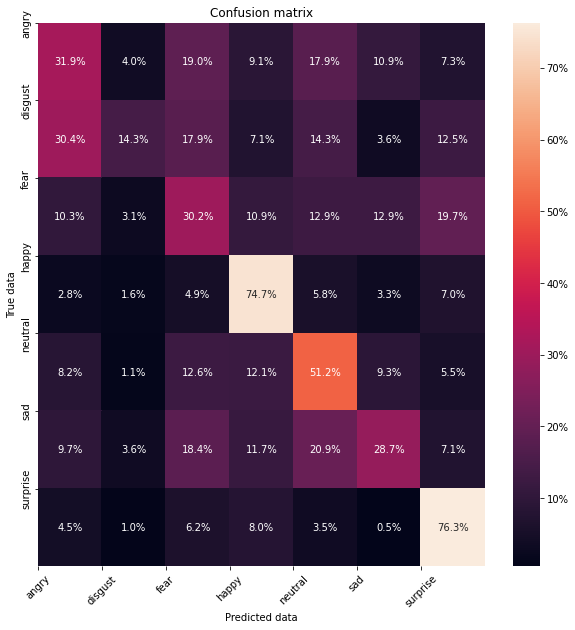

In [ ]:
#confusion matrix for Basic model version 9
plot_confusion_matrix(cnn9)

1/1 [==============================] - 15s 15s/step


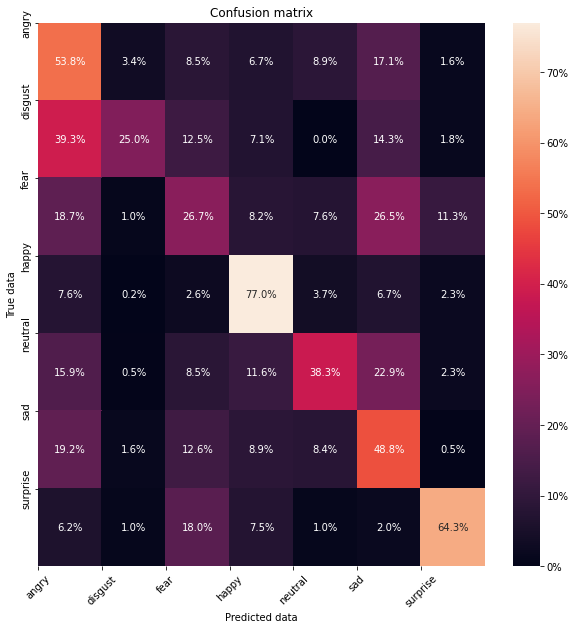

In [ ]:
#confusion matrix for AlexNet model version 2.2
plot_confusion_matrix(AlexNetv22_model_)